In [1]:
from huggingface_hub import notebook_login

# 登录huggingface
notebook_login()

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
    """给定一批图像，创建一个网格并将其转换为PIL"""
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    """给定一个PIL图像列表，将它们叠加成一行以便查看"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 加载管线
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

safety_checker\model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

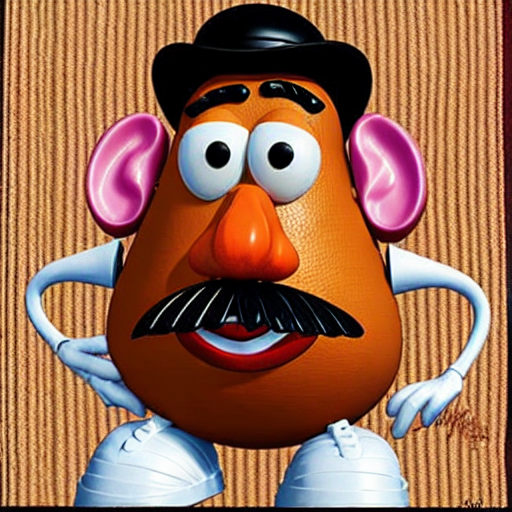

In [4]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=5.5).images[0]
image

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

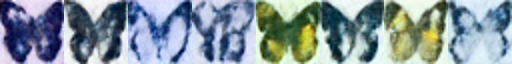

In [5]:
from diffusers import DDPMPipeline

# 加载预设好的管线
model = "johnowhitaker/ddpm-butterflies-32px"
butterfly_pipeline = DDPMPipeline.from_pretrained(model).to(device)

# 生成8张图片
images = butterfly_pipeline(batch_size=8).images

make_grid(images)

In [6]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

image_size = 32
batch_size = 64

# 定义数据增强过程
preprocess = transforms.Compose(
[
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

X shape: torch.Size([8, 3, 32, 32])


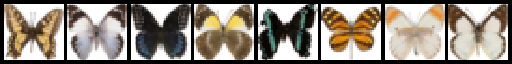

In [7]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [8]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

Nosiy X Shape torch.Size([8, 3, 32, 32])


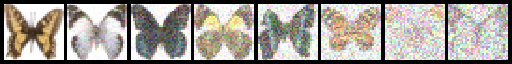

In [9]:
# 添加不同程度的噪声
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.rand_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Nosiy X Shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,   # 目标图像的分辨率
    in_channels=3,            
    out_channels=3,           
    layers_per_block=2,       # 每一个UNet块中的ResNet层数
    block_out_channels=(64, 128, 128, 256), 
    down_block_types=( 
        "DownBlock2D",        
        "DownBlock2D",
        "AttnDownBlock2D",    # 带有空域维度的self-att的ResNet下采样模块
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # 带有空域维度的self-att的ResNet上采样模块
        "UpBlock2D",  
        "UpBlock2D"
      ),
)

model.to(device);

with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample

model_prediction.shape

torch.Size([8, 3, 32, 32])